# 模型构建

回顾之前，含单隐藏层的多层感知机的实现方法。我们首先构造 `Sequential` 实例，然后依次添加两个全连接层。其中第一层的输出大小为256，即隐藏层单元个数是256。第二层的输出大小为10，即输出层单元个数是10。外面在上一章的其他节点中也使用了`Sequential`类构造模型。这里我们介绍另外一种基于`Module`类的模型构造方法：它让模型构造更加灵活。

## 继承MODULE类来构造模型

`Module`类是`nn`模块里提供的一个模型构造类，是所有神经网络的基类，我们可以继承它来定义我们想要的模型。下面继承`Module`类构造本节开头提到的多层感知机。这里定义的`MLP`类重载了`Module`类的 `__init__`函数和`forward`函数。它们分别用于创建模型参数和定义前向计算。前向计算即正向传播。

In [2]:
import torch
from torch import nn

class MLP(nn.Module):
    # 声明带有模型参数的层，这里声明了两个全连接层
    def __init__(self,**kwargs):
        # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
        # 参数
        super(MLP,self).__init__(**kwargs)
        self.hidden = nn.Linear(784,256) #隐藏层
        self.act = nn.ReLU()
        self.output = nn.Linear(256,10) #输出层
    
    # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
    def forward(self,X):
        a = self.act(self.hidden(X)) # 对隐藏层的输出层的激活函数
        return self.output(a)

以上的`MLP` 类中无须定义反向传播函数。系统将通过自动求梯度而自动生成反向传播所需的 `backward` 函数。`__init__`中`nn.Linear`层会自动生成权重和偏置，并默认使用 Xavier 均匀分布初始化权重、0 初始化偏置，无需手动干预。

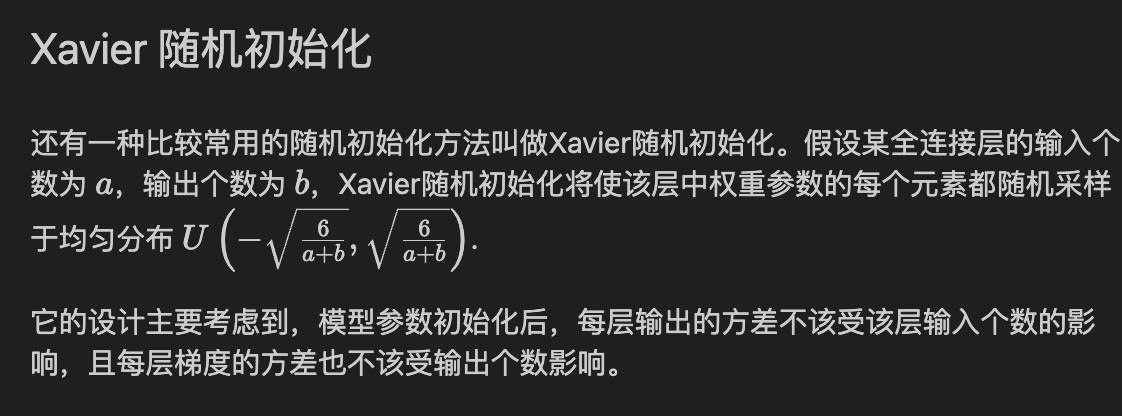

我们可以实例化 `MLP`类得到的模型变量 `net`。下面的代码初始化`net`并传入输入数据 `x`做一次前向计算。其中`net(X)`会调用`MLP`继承自`Module`类的`__call__`函数，这个函数将调用`MLP`类定义的`forward`函数来完成前向计算

In [4]:
X = torch.rand(2,784)
net = MLP()
print(net)
net(X)

MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[ 0.0388, -0.0173,  0.0653,  0.2450, -0.1495, -0.0517,  0.2107,  0.0419,
         -0.0124,  0.1502],
        [ 0.0822, -0.0154,  0.1390,  0.2027, -0.0975, -0.0485,  0.1974,  0.0656,
          0.0542,  0.1339]], grad_fn=<AddmmBackward0>)

这里并没有将`Module`类命名为 `layer`，这时因为该类是一个可供自由组建的部件。它的子类既可以是一个层，又可以是一个模型，或者模型的一部分。下面举例来展示它的灵活性

## Module子类

`Module`类是一个通用的部件。事实上，pytorch还实现了继承来自`Module`的可以方便构建模型的类：如`Sequential`、`ModuleList`和`ModuleDict`等

当模型的前向计算为简单串联各个层的计算时， `Sequential` 类可以通过更加简单的⽅式定义模型。这正是 `Sequential` 类的⽬的：它可以接收⼀个⼦模块的有序字典（`OrderedDict`）或者⼀系列⼦模块作为参数来逐⼀添加 `Module` 的实例，⽽模型的前向计算就是将这些实例按添加的顺序逐⼀计算。下⾯我们实现⼀个与 S`equential` 类有相同功能的 `MySequential` 类。这或许可以帮助读者更加清晰地理解 Sequential 类的⼯作机制

In [7]:
# 此案例展示了MOdule可以传入模型，使数据依次训练模型
class MySequential(nn.Module):
    from collections import OrderedDict
    def __init__(self,*args):
        super(MySequential,self).__init__()
        if len(args) == 1 and isinstance (args[0],OrderedDict): #判断传入的是否为单个模型字典，如果是则加入self中。
            for key,module in args[0].items(): #key 为名称，module为模型
                self.add_module(key,module)
        else:
            for idx,module in enumerate(args): #enumerate(args) 遍历传入的模块 类似 range(num_epochs)
                self.add_module(str(idx),module)
    def forward(self,input):
        for module in self._modules.values():
            input = module(input)
        return input

用 `MySequential`类来实现前面描述的 `MLP`类，并使用随机初始化的模型做一次前向计算。

In [13]:
import torch.nn as nn

# 方式1：传入多个模块（按位置参数）
model1 = MySequential(
    nn.Linear(784, 256),  # 第0层：线性层
    nn.ReLU(),            # 第1层：激活函数
    nn.Linear(256, 10)    # 第2层：输出层
)

# 方式2：传入OrderedDict（指定模块名）
from collections import OrderedDict
model2 = MySequential(
    OrderedDict([
        ('fc1', nn.Linear(784, 256)),  # 模块名'fc1'
        ('relu1', nn.ReLU()),          # 模块名'relu1'
        ('fc2', nn.Linear(256, 10))    # 模块名'fc2'
    ])
)

# 前向传播（输入→层0→层1→层2→输出）
x = torch.randn(1, 784)  # 输入张量（1个样本，784个特征）
print(model1(x).shape)  # 输出：torch.Size([1, 10])（与最后一层输出维度一致）
print(model2(x).shape)

torch.Size([1, 10])
torch.Size([1, 10])


## ModuleList 类

`ModuleList`接收一个子模块的列表作为输入，然后也可以类似List那样进行append和extend操作

In [15]:
net = nn.ModuleList([nn.Linear(784,256),nn.ReLU()])
net.append(nn.Linear(256,10))
print(net[-1])
print(net)

Linear(in_features=256, out_features=10, bias=True)
ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


## ModuleDict 类

`ModuleDict`接受一个子模块的字典作为输入，然后也可以类似字典那样进行访问操作

In [18]:
net = nn.ModuleDict({
    'linear':nn.Linear(784,256),
    'act':nn.ReLU(),
})
net['output'] = nn.Linear(256,10)
print(net['linear'])
print(net.output)
print(net['output'])
print(net)

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)
Linear(in_features=256, out_features=10, bias=True)
ModuleDict(
  (linear): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


## 复杂的模型

上面介绍的这些类可以使模型构造更加简单，且不需要定义 `forward` 函数，但直接继承 `Module`类可以极大地拓展模型构造的灵活性。下面构造一个稍微复杂点的网络`FancyMLP`。在这个网络中，我们通过`get_constant`函数创建训练中不被迭代的参数，即常数参数。前向计算中，除了使用创建的常数参数外，我们还使用`tensor`的函数和python的控制流，并多次调用相同的层

In [21]:
class FancyMLP(nn.Module):
    def __init__(self,**kwarge):
        super(FancyMLP,self).__init__(**kwarge)

        self.rand_weight = torch.rand((20,20),requires_grad=False) #不可训练参数（常数参数）
        self.linear = nn.Linear(20,20)

    def forward(self,X):
        X = self.linear(X)
        X = nn.functional.relu(torch.mm(X,self.rand_weight.data)+1)
        X = self.linear(X)
        while X.norm().item()>1: #L2 范数
            X /=2
        if X.norm().item()<0.8:
            X *= 10
        return X.sum()

In [22]:
X = torch.rand(2,20)
net = FancyMLP()
print(net)
net(X)

FancyMLP(
  (linear): Linear(in_features=20, out_features=20, bias=True)
)


tensor(4.9205, grad_fn=<SumBackward0>)

因为`FancyMLP` 和`sequential` 类都是`Module`类的子类，所以我们可以嵌套调用

In [23]:
class NestMLP(nn.Module):
    def __init__(self,**kwargs):
        super(NestMLP,self).__init__(**kwargs)
        self.net = nn.Sequential(nn.Linear(40,30),nn.ReLU())
    
    def forward(self,X):
        return self.net(X)

net = nn.Sequential(NestMLP(),nn.Linear(30,20),FancyMLP())

X = torch.rand(2,40)
print(net)
net(X)

Sequential(
  (0): NestMLP(
    (net): Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): ReLU()
    )
  )
  (1): Linear(in_features=30, out_features=20, bias=True)
  (2): FancyMLP(
    (linear): Linear(in_features=20, out_features=20, bias=True)
  )
)


tensor(-0.0431, grad_fn=<SumBackward0>)

## 小结

可以通过继承 `Module`类来构造模型

`Sequential`、`ModuleList`、`ModuleDict`类都继承自`Module`类

虽然`Sequentiral`等类可以使模型构造更加简单，但直接继承`Module`类可以极大拓展模型构造的灵活性

# 模型参数的访问、初始化和共享

先定义一个与上文相同的含单隐藏层的多层感知机。我们依然使用默认方式初始化它的参数，并做一次前向计算。与之不同的是，在这里我们从`nn`中导入了`init`模块，它包含了多种模型的初始化方法。

In [39]:
import torch
from torch import nn
from torch.nn import init 
net = nn.Sequential(nn.Linear(4,3),nn.ReLU(),nn.Linear(3,1))
#pytorch已进⾏默认初始化
print(net)
X = torch.rand(2,4)
y = net(X).sum()

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


## 访问模型参数

对于 `Sequential`实例中含模型参数的层，我们可以通过`Module`类的`parameters()`或者`named_parameters`方法来访问所有参数，后者除了返回参`Tensor`外还会返回其名字。下面访问多层感知机 `net`的所有参数

In [25]:
print(type(net.named_parameters()))
for name,param in net.named_parameters():
    print(name,param.size())

<class 'generator'>
0.weight torch.Size([3, 4])
0.bias torch.Size([3])
2.weight torch.Size([1, 3])
2.bias torch.Size([1])


可见返回的名字自动加上了层数的索引作为前缀。我们再来访问 `net`中单层的参数。对于使用`Sequential`类构造的神经网络，我们可以通过方括号[]来访问网络的任一层。索引0表示隐藏层为 `Sequential`实例最先添加的层

In [26]:
for name,param in net[0].named_parameters():
    print(name,param.size(),type(param))

weight torch.Size([3, 4]) <class 'torch.nn.parameter.Parameter'>
bias torch.Size([3]) <class 'torch.nn.parameter.Parameter'>


因为这里是单层的所以没有了层数索引的前缀。另外返回的`param`的类型为`torch.nn.parameter`，其实这是`Tensor`的子类，和`Tensor`不同的是如果一个`Tensor`是`parameter`，那么它会自动被添加到模型的参数列表里

In [38]:
class MyModule(nn.Module):
    def __init__(self,**kwargs):
        super(MyModule,self).__init__(**kwargs)
        self.weight1 = nn.Parameter(torch.rand(20, 20))
        self.weight2 = torch.rand(20,20)
    def forward(self,X):
        pass
n = MyModule()
for name,param in n.named_parameters():
    print(name) #访问参数的结果是 weight1

weight1


上面的代码中`weight1`在参数列表中但是`weight2`没在参数列表中。

因为`Parameter`是`Tensor`，即`Tensor`拥有的属性它都有，比如可以根据`data`来访问参数数值，用`grad`来访问参数梯度。

```python
net = nn.Sequential(nn.Linear(4,3),nn.ReLU(),nn.Linear(3,1))
#pytorch已进⾏默认初始化
print(net)
X = torch.rand(2,4)
y = net(X).sum()
```

In [40]:
weight_0  = list(net[0].parameters())[0] #第一个模型的权重参数
print(weight_0.data)
print(weight_0.grad)
y.backward()
print(weight_0.grad)

tensor([[ 0.0896, -0.3928,  0.0482, -0.1502],
        [ 0.2412,  0.1290,  0.3523,  0.4270],
        [-0.3508, -0.3322, -0.0866, -0.3855]])
None
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1427, -0.2415, -0.2005, -0.1844],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])


## 初始化模型参数

上文提到 `nn.Module`的模块参数都采用了较为合理的初始化策略。但我们经常需要使用其他方法来初始化权重。`init`模块里提供了多种预设的初始化方法

在下文中，我们将权重参数初始化为均值0，标准差0.01的正态分布随机数，并依然将偏差参数清零。

In [42]:
for name,param in net.named_parameters():
    if 'weight' in name: # 遍历后的判断，只处理weight权重参数
        init.normal_(param,mean=0,std=0.01)
        print(name,param.data)

0.weight tensor([[-8.5351e-03,  7.3638e-03,  1.2481e-03,  4.4623e-03],
        [-5.4149e-03, -1.8623e-02, -2.1432e-03, -1.9369e-03],
        [ 6.0659e-05, -3.2219e-04,  6.4911e-03, -6.6624e-03]])
2.weight tensor([[-0.0036, -0.0149, -0.0032]])


常数来初始化权重参数。

In [43]:
for name,param in net.named_parameters():
    if 'bias' in name:
        init.constant_(param,val=0)
        print(name,param.data)

0.bias tensor([0., 0., 0.])
2.bias tensor([0.])


## 自定义初始化方法

有时需要的初始化方法并没有在 `init` 模块中提供。这时可以实现一个初始化方法，从而能够像使用其他初始化方法那样使用。在这之前先看看`Pytorch`是怎么实现这些初始化方法的。例如`torch.nn.init.normal_`

In [44]:
def normal_(tensor,mean=0,std=1):
    with torch.no_grad():
        return tensor.normal_(mean,std)

这就是⼀个`inplace`改变 `Tensor` 值的函数，⽽且这个过程是不记录梯度的。 类似的我们来实现⼀个⾃定义的初始化⽅法。在下⾯的例⼦⾥，我们令权重有⼀半概率初始化为0，有另一半概率初始化为[-10,5]和[5,10]区间里的均匀分布的随机数

In [45]:
def init_weight_(tensor):
    with torch.no_grad():
        tensor.uniform_(-10,10)
        tensor *=(tensor.abs()>=5).float()

for name,param in net.named_parameters():
    if 'weight' in name:
        init_weight_(param)
        print(name,param.data)

0.weight tensor([[ 0.0000,  9.9050, -0.0000, -0.0000],
        [-8.0450, -0.0000,  0.0000, -5.9152],
        [-7.9967,  0.0000, -6.2345,  5.4338]])
2.weight tensor([[-5.4876, -9.1893,  6.7305]])


还可以通过改变参数的 `data`来改写模型参数值同时不会影响梯度。

In [46]:
for name,param in net.named_parameters():
    if 'bias' in name:
        param.data +=1
        print(name,param.data)

0.bias tensor([1., 1., 1.])
2.bias tensor([1.])


## 共享参数模型

有些情况我们希望在多个层之间共享参数模型。`Module`类的`forward`函数里多次调用了一个层。此外，如果传入`Sequential`的模块是同一个`Module`实例的话，参数也是共享的。

In [52]:
linear = nn.Linear(1,1,bias=False)
net = nn.Sequential(linear,linear)
print(net)
for name,param in net.named_parameters():
    init.constant_(param,val=3)
    print(name,param.data)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=False)
  (1): Linear(in_features=1, out_features=1, bias=False)
)
0.weight tensor([[3.]])


内存中，这两个线性层其实一个对象。

In [54]:
print(id(net[0]) == id(net[1]))
print(id(net[0].weight) == id(net[1].weight))

True
True


因为模型参数⾥包含了梯度，所以在反向传播计算时，这些共享的参数的梯度是累加的:

In [56]:
X= torch.ones(1,1)
y = net(X).sum()
print(y)
y.backward()
print(net[0].weight.grad) #单次梯度是3，两次梯度就是6

tensor(9., grad_fn=<SumBackward0>)
tensor([[12.]])


## 小结

有多种方法来访问、初始化和共享模型参数

可以自定义初始化方法

# 自定义层

深度学习的一个魅力在于神经网络中各种各样的层，例如全连接层和后文中的卷积层、池化层和循环层。虽然`Pytorch`提供了大量常用的层，但有时候我们依然希望自定义层。这里介绍如何使用`Module`来自定义层，从而可以被重复调用。

## 不含模型参数的自定义层

先介绍如何定义一个不含模型参数的自定义层。下面代码示例的`CenteredLayer`类通过继承`Module`类自定义一个将输入减掉均值后输出的层，并将层的计算定义在了`forward`函数里。这个层里不含模型参数。

In [58]:
import torch
from torch import nn

class CenteredLayer(nn.Module):
    def __init__(self,**kwargs):
        super(CenteredLayer,self).__init__(**kwargs)
    def forward(self,X):
        return X-X.mean()

In [59]:
# 实例化这个层，然后做前向计算。
layer = CenteredLayer()
layer(torch.tensor([1,2,3,4,5],dtype=torch.float))

tensor([-2., -1.,  0.,  1.,  2.])

In [60]:
net = nn.Sequential(nn.Linear(8,128),CenteredLayer())

In [ ]:
y = net(torch.rand(4,8))
y.mean().item()

-5.587935447692871e-09

## 含模型参数的自定义层

我们还可以⾃定义含模型参数的⾃定义层。其中的模型参数可以通过训练学出。

在前文中介绍了 `Parameter`类其实是`Tensor`的子类，如果一个`Tensor`是`Parameter`，那么它会自动被添加到模型的参数列表里。所以在自定义含模型参数的层时，我们应该将参数定义成`Parameter`。除了使用`Parameter`类外，还可以使用`ParameterList`和`ParameterDict`分别定义参数的列表和字典。

`ParameterList`接收一个`Parameter`实例的列表作为输入然后得到一个参数列表，使用时可以用索引来访问某个参数，另外也可以使用`append`和`extend`在列表后面新增参数。

In [72]:
class MyDense(nn.Module):
    def __init__(self):
        super(MyDense,self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(4,4))for i in range(3)])
        self.params.append(nn.Parameter(torch.randn(4,1))) # 拼接在ParameterList 后面

    def forward(self,X):
        for i in range(len(self.params)):
            X = torch.mm(X,self.params[i])
        return X
net = MyDense()
print(net)

MyDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 4x4]
      (1): Parameter containing: [torch.FloatTensor of size 4x4]
      (2): Parameter containing: [torch.FloatTensor of size 4x4]
      (3): Parameter containing: [torch.FloatTensor of size 4x1]
  )
)


而 `ParameterDict`接收一个`Parameter`实例的字典作为输入然后得到一个参数字典，然后可以按照字典的规则适用了。例如使用`updata()`新增参数，使用`keys()`返回所有键值，使用`items()`返回所有键值对等等

In [69]:
class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense,self).__init__()
        self.params = nn.ParameterDict({
            'linear1':nn.Parameter(torch.randn(4,4)),
            'linear2':nn.Parameter(torch.randn(4,1))
        })
        self.params.update({'linear3':nn.Parameter(torch.randn(4,2))})
    def forward(self,X,choice='linear1'):
        return torch.mm(X,self.params[choice])
    
net = MyDictDense()
print(net)

MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


In [70]:
X = torch.ones(1,4)
print(net(X,'linear1'))
print(net(X,'linear2'))
print(net(X,'linear3'))

tensor([[ 3.6704,  1.4597, -1.5958, -0.2782]], grad_fn=<MmBackward0>)
tensor([[1.7112]], grad_fn=<MmBackward0>)
tensor([[-0.0769, -1.5579]], grad_fn=<MmBackward0>)


也可以使用自定义层构造模型。

In [73]:
net = nn.Sequential(
    MyDictDense(),
    MyDense(),
)
print(net)
print(net(X))

Sequential(
  (0): MyDictDense(
    (params): ParameterDict(
        (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
        (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
        (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
    )
  )
  (1): MyDense(
    (params): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 4x4]
        (1): Parameter containing: [torch.FloatTensor of size 4x4]
        (2): Parameter containing: [torch.FloatTensor of size 4x4]
        (3): Parameter containing: [torch.FloatTensor of size 4x1]
    )
  )
)
tensor([[16.4964]], grad_fn=<MmBackward0>)


## 小结

可以通过`Module`类自定义神经网络中的层，从而可以被重复调用

# 读取和存储

目前为止，我们介绍了如何处理数据以及如何构建、训练和测试深度学习模型。然后我们有时需要把训练好的模型部署到很多不同的设备。在这种情况下，我们可以把内存中训练好的模型参数存储在硬盘上供后续读取使用

## 读写Tensor

我们可以直接使用`save`函数和`load`函数分别存储和读取`Tensor`。`save`使用python的pickle实用程序将对象进行序列化，然后将序列化的对象保存到dick，使用`save`可以保存各种对象，包括模型、张量和字典。而`load`使用pickle unpickle工具将pickle的对象文件反序列化为内存。即`save`保存；`load`读取

下面的例子创建了`Tensor`变量`X`，并将其存在文件名同为`X.pt`的文件里

In [77]:
import torch
from torch import nn
X = torch.ones(3)
torch.save(X,'X.pt')

In [78]:
X2 = torch.load('X.pt')
X2

tensor([1., 1., 1.])

In [79]:
y = torch.zeros(4)
torch.save([X,y],'xy.pt')
xy_list = torch.load('xy.pt')
xy_list

[tensor([1., 1., 1.]), tensor([0., 0., 0., 0.])]

In [81]:
torch.save({'x': X, 'y': y}, 'xy_dict.pt')
xy = torch.load('xy_dict.pt')
xy

{'x': tensor([1., 1., 1.]), 'y': tensor([0., 0., 0., 0.])}

## 读写模型

在Pytorch中，`Module`的可学习参数，模块模型包含在参数重（通过`model.parameters()`访问）。`state_dict`是一个从参数名称转换到参数`Tensor`的字典对象

In [82]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.hidden = nn.Linear(3,2)
        self.act = nn.ReLU()
        self.output = nn.Linear(2,1)

    def forward(self,X):
        a = self.act(self.hidden(X))
        return self.output(a)
    
net = MLP()
net.state_dict()

OrderedDict([('hidden.weight',
              tensor([[-0.2157,  0.5406,  0.4806],
                      [ 0.2829, -0.2182, -0.0377]])),
             ('hidden.bias', tensor([0.4059, 0.2456])),
             ('output.weight', tensor([[ 0.5026, -0.2916]])),
             ('output.bias', tensor([0.4184]))])

注意，只有具有可学习参数的层(卷积层、线性层等)才有 `state_dict` 中的条⽬。优化器( `optim` )也有⼀个 `state_dict` ，其中包含关于优化器状态以及所使⽤的超参数的信息

# GPU 计算

目前为止，我们一直在使用CPU计算。对复杂的神经网络和大规模的数据来说，使用CPU来计算可能不太高效。在本节中，我们将介绍如何使用GPU来计算。所以确保已经安装好了GPU版本

In [15]:
import torch
import torch.nn as nn

In [9]:
import torch

x = torch.tensor([1, 2, 3])
x = x.to("mps")  # 或 x = x.mps()，将张量移到MPS设备
print(x)

tensor([1, 2, 3], device='mps:0')


In [10]:
X = torch.tensor([1,2,3],device='mps')
print(X.device)

mps:0


In [11]:
device = torch.device('mps' if torch.backends.mps.is_available() else'cpu')
x = torch.tensor([1,2,3],device=device)
print(x)

tensor([1, 2, 3], device='mps:0')


In [12]:
y = x**2
y

tensor([1, 4, 9], device='mps:0')

需要注意的是，存储在不同位置中的数据是不可以直接进⾏计算的。即存放在CPU上的数据不可以直接
与存放在GPU上的数据进⾏运算，位于不同GPU上的数据也是不能直接进⾏计算的。

In [13]:
z = y +x.cpu()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

## 模型的GPU计算

同`Tensor`类似，Pytorch模型可以通过`.device`转换搭配GPU上。我们可以通过检查模型的参数device属性来查看存放模型的设备

In [17]:
net = nn.Linear(3,1)
list(net.parameters())[0].device

device(type='cpu')

In [19]:
net.to('mps')
list(net.parameters())[0].device

device(type='mps', index=0)

同样的，我们需要保证模型输入的`Tensor`和模型都在同一个设备上，否则会报错

In [20]:
x = torch.rand(2,3).to('mps')
net(x)

/opt/miniconda3/envs/torch-new/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[-0.6501],
        [-0.2778]], device='mps:0', grad_fn=<MpsLinearBackward0>)

## 小结

pytorch 可以指定用来存储和计算的设备，如用内存的CPU或者使用显存的GPU。在默认情况下，Pytorch会将数据创建在内存，然后利用CPU来计算

pytorch 要求计算的所有输入数据都在内存或同一块显卡的显存上